<a href="https://colab.research.google.com/github/makhijakabir/plantDiseaseDetection/blob/main/plantDiseaseDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mini Project for Sem 5 CSBS

##Topic: Plant Disease Detection

###This project analyses more than 4,870 images from Pepper Bell, Potato, and Tomato plants' leaves for 3 different kinds of viruses and diseases and categorises them accordingly.

##Imports and Constants

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --upgrade pip --user
!pip install tensorflow --user
!pip install tqdm

     |████████████████████████████████| 1.7 MB 5.5 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
import keras
import itertools
import sys
from tqdm import tqdm

import pickle
import cv2

from keras.models import Sequential
from keras.layers import BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras.callbacks import TensorBoard
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

from time import strftime

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from IPython.display import display

import matplotlib.pyplot as plt

In [30]:
nrEpochs = 5
initLearnRate = 1e-3
batchSize = 32
nrClasses = 6

imgSizeDefault = tuple((256, 256))
imgSize = 500
directoryRoot = '/content/drive/MyDrive/Colab Notebooks/PlantVillageShort'

width = 256
height = 256
depth = 3

categories = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_healthy']
#type(categories)

In [5]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/PlantVillageShort')
!pwd
rootDIR = os.path.abspath('')
print(rootDIR)
sys.path.append(rootDIR)

/content/drive/MyDrive/Colab Notebooks/PlantVillageShort
/content/drive/MyDrive/Colab Notebooks/PlantVillageShort


In [6]:
xFile = os.path.join(directoryRoot, 'X.pickle')
yFile = os.path.join(directoryRoot, 'y.pickle')

In [7]:
pickle_in = open(xFile,"rb")
X = pickle.load(pickle_in)

pickle_in = open(yFile,"rb")
y = pickle.load(pickle_in)

In [8]:
y = np.array(y)
print(X,"\n\n", y)

[[[[136]
   [133]
   [129]
   ...
   [120]
   [133]
   [140]]

  [[143]
   [138]
   [129]
   ...
   [121]
   [130]
   [135]]

  [[155]
   [146]
   [129]
   ...
   [123]
   [124]
   [125]]

  ...

  [[ 85]
   [ 84]
   [ 84]
   ...
   [ 69]
   [ 68]
   [ 67]]

  [[ 80]
   [ 80]
   [ 79]
   ...
   [ 69]
   [ 67]
   [ 66]]

  [[ 78]
   [ 78]
   [ 77]
   ...
   [ 69]
   [ 67]
   [ 66]]]


 [[[116]
   [116]
   [117]
   ...
   [ 68]
   [ 84]
   [ 92]]

  [[111]
   [111]
   [112]
   ...
   [ 70]
   [ 80]
   [ 85]]

  [[102]
   [102]
   [102]
   ...
   [ 74]
   [ 72]
   [ 72]]

  ...

  [[148]
   [147]
   [145]
   ...
   [142]
   [140]
   [139]]

  [[149]
   [148]
   [146]
   ...
   [141]
   [138]
   [137]]

  [[150]
   [149]
   [147]
   ...
   [141]
   [138]
   [136]]]


 [[[128]
   [128]
   [129]
   ...
   [141]
   [140]
   [140]]

  [[130]
   [130]
   [131]
   ...
   [139]
   [139]
   [139]]

  [[134]
   [134]
   [135]
   ...
   [137]
   [137]
   [138]]

  ...

  [[ 67]
   [ 67]
   [ 67]
   

In [9]:
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3)

XTrain, XVal, yTrain, yVal = train_test_split(XTrain, yTrain, test_size=0.2, random_state=44)


print("Train features shape: ", XTrain.shape)
print("Train target shape: ", yTrain.shape)
print("Train features shape: ", XTest.shape)
print("Train target shape: ", yTest.shape)
print("Validation features shape: ", XVal.shape)
print("Validation target shape: ", yVal.shape)

Train features shape:  (2727, 500, 500, 1)
Train target shape:  (2727,)
Train features shape:  (1461, 500, 500, 1)
Train target shape:  (1461,)
Validation features shape:  (682, 500, 500, 1)
Validation target shape:  (682,)


In [10]:
yTrain = yTrain.reshape(-1,)
yTest = yTest.reshape(-1,)

In [11]:
cnn = Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(500, 500, 1)),
    layers.MaxPooling2D((2, 2)),
    #layers.Dropout(0.5),
    
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Dropout(0.25),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Dropout(0.25),

    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(8, activation='softmax')
])

In [12]:
type(cnn)

keras.engine.sequential.Sequential

In [13]:
cnn.compile(optimizer='RMSprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 128)    0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 64)      73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 64)       0

In [15]:
%%time
cnnModel = cnn.fit(XTrain, yTrain, batch_size=batchSize, epochs=nrEpochs, validation_data=(XVal, yVal))

Epoch 1/5
86/86 [==============================] - 70s 632ms/step - loss: 5.0475 - accuracy: 0.4712 - val_loss: 0.8520 - val_accuracy: 0.6598
Epoch 2/5
86/86 [==============================] - 57s 664ms/step - loss: 0.9822 - accuracy: 0.6439 - val_loss: 0.9622 - val_accuracy: 0.7595
Epoch 3/5
86/86 [==============================] - 57s 662ms/step - loss: 0.7455 - accuracy: 0.7737 - val_loss: 0.5382 - val_accuracy: 0.8710
Epoch 4/5
86/86 [==============================] - 57s 662ms/step - loss: 0.6364 - accuracy: 0.8177 - val_loss: 2.0075 - val_accuracy: 0.6217
Epoch 5/5
86/86 [==============================] - 57s 664ms/step - loss: 0.5951 - accuracy: 0.8695 - val_loss: 0.4161 - val_accuracy: 0.8842
CPU times: user 3min 29s, sys: 4.57 s, total: 3min 34s
Wall time: 4min 58s


In [16]:
cnn.evaluate(XTest, yTest)

46/46 [==============================] - 11s 237ms/step - loss: 0.4576 - accuracy: 0.8597


[0.45762738585472107, 0.8596851229667664]

In [17]:
yPred = cnn.predict(XTest)
yPred[:5]

array([[8.91330419e-04, 1.66615546e-01, 8.23354781e-01, 9.13732592e-03,
        5.60073907e-08, 2.21394691e-12, 9.53089113e-07, 6.40720310e-10],
       [2.34951152e-08, 9.99761283e-01, 2.37809363e-04, 9.58194960e-07,
        4.24332054e-12, 2.11732921e-20, 5.34091543e-16, 8.72884616e-19],
       [3.67556140e-02, 1.12469539e-01, 8.08206797e-01, 4.22106832e-02,
        3.19330029e-05, 2.03894032e-07, 3.18503706e-04, 6.73665863e-06],
       [3.67275888e-25, 4.71218482e-06, 1.03591455e-08, 9.99995232e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.48106594e-34],
       [3.65566625e-03, 2.99660452e-02, 9.64489162e-01, 1.86335971e-03,
        7.43538010e-07, 1.09164969e-10, 2.49736204e-05, 2.63745150e-08]],
      dtype=float32)

In [18]:
yClasses = [np.argmax(element) for element in yPred]
print("Predicted Classes: ", yClasses[:10])

Predicted Classes:  [2, 1, 2, 3, 2, 2, 3, 2, 2, 3]


In [19]:
print("Actual Classes: ", yTest[:10])

Actual Classes:  [1 1 2 3 2 1 3 2 1 1]


In [20]:
testLoss, testAccuracy = cnn.evaluate(XTest, yTest)
print(f'The Test Loss is {testLoss:0.3} and the Test Accuracy is {testAccuracy:0.1%}')

46/46 [==============================] - 8s 179ms/step - loss: 0.4576 - accuracy: 0.8597
The Test Loss is 0.458 and the Test Accuracy is 86.0%


In [21]:
target_names = ["Class {}".format(i) for i in range(8)]
print(classification_report(yTest, yClasses, labels=[1, 2, 3, 4, 5, 6], target_names=categories))

correct = np.nonzero(yClasses == yTest)[0]
incorrect = np.nonzero(yClasses != yTest)[0]

                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.81      0.54      0.64       302
       Pepper__bell___healthy       0.82      0.97      0.89       632
             Potato___healthy       0.96      0.96      0.96       486
         Potato___Late_blight       0.00      0.00      0.00         0
        Tomato_Bacterial_spot       0.00      0.00      0.00         0
               Tomato_healthy       0.00      0.00      0.00         0

                    micro avg       0.87      0.87      0.87      1420
                    macro avg       0.43      0.41      0.42      1420
                 weighted avg       0.86      0.87      0.86      1420



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

In [26]:
predictions = cnn.predict(XTest)
predictions = np.argmax(predictions, axis=-1)

confMatrix = confusion_matrix(y_true=yTest, y_pred=predictions)

In [27]:
confMatrix.shape

(4, 4)

In [28]:
nrRows = confMatrix.shape[0]
nrCols = confMatrix.shape[1]

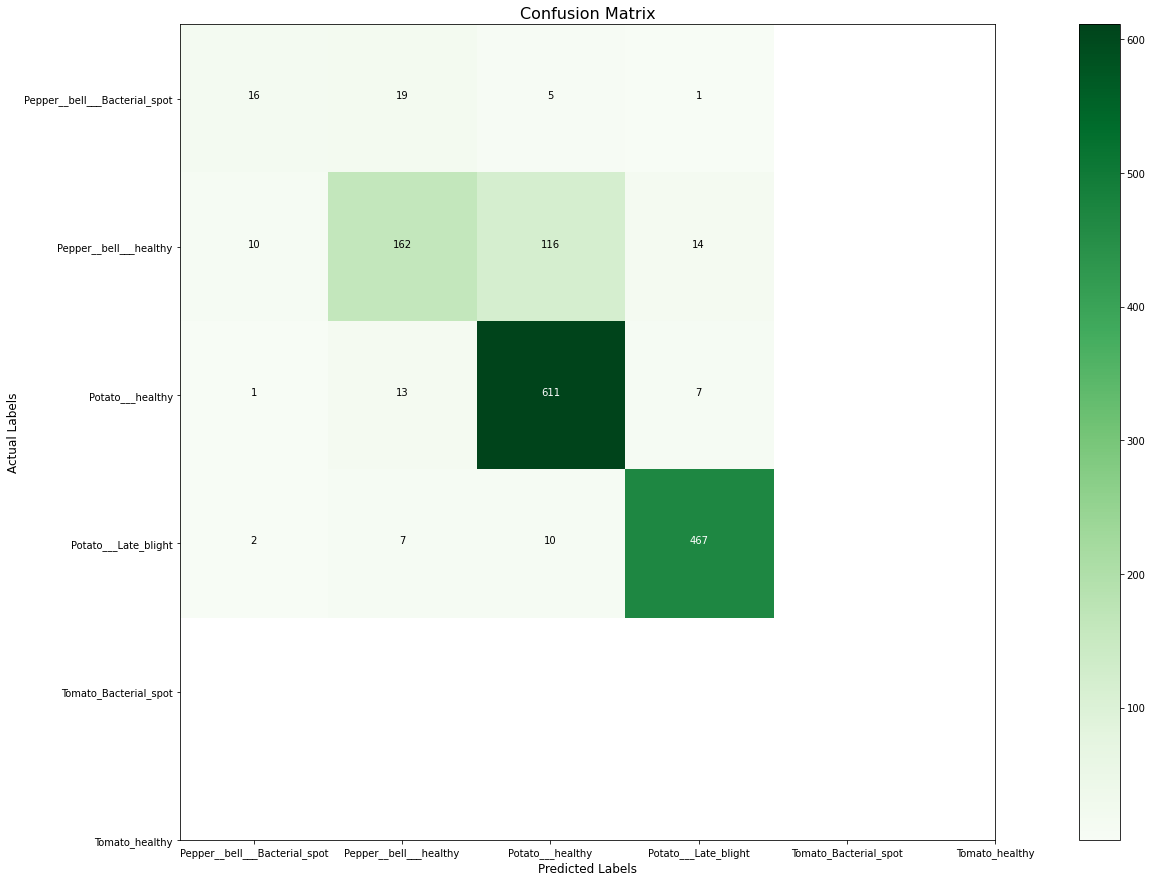

In [40]:
plt.figure(figsize=(30, 15))
plt.imshow(confMatrix, cmap=plt.cm.Greens)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)

tickMarks = np.arange(nrClasses)
plt.yticks(tickMarks, categories)
plt.xticks(tickMarks, categories)

plt.colorbar()

for i, j in itertools.product(range(nrRows), range(nrCols)):
    plt.text(j, i, confMatrix[i, j], horizontalalignment='center', color='white' if confMatrix[i, j] > confMatrix.max()/2 else 'black')

plt.show()

In [41]:
truePositive = np.diag(confMatrix)

In [42]:
recall = truePositive / np.sum(confMatrix, axis=1)
recallModel = np.mean(recall)
print(f'The Recall score of the Model 2 is: {recallModel:.2%}')

The Recall score of the Model 2 is: 71.36%


In [43]:
precision = truePositive / np.sum(confMatrix, axis=0)
precisionModel = np.mean(precision)
print(f'The Precision score of the Model 2 is: {precisionModel:.2%}')

The Precision score of the Model 2 is: 78.40%


In [44]:
fScore = 2 * precisionModel * recallModel / (precisionModel + recallModel)
print(f'The F Score of the Model 2 is: {fScore:.2%}')

The F Score of the Model 2 is: 74.72%
